# Classification

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.8MB/s 
     |████████████████████████████████| 9.5MB 24.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Google Colab Setup

In [2]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pickle import dump, load

# Scikit-Learn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [3]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Drive path is the path where I upload the ETFs history file and pre-written pyfile
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move these file into the local path
local_path = '/content'

In [6]:
# Copy these file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change these file from drive path to the local path
os.chdir(local_path)

In [7]:
# Pre-written function
import util as ut

## Preprocessing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [9]:
# Select one REIT ETF
vnq = data.copy().loc[data['Ticker'] == "VNQ"]

In [10]:
# Drop unnecessary columns
vnq.drop(columns=['Volume', 'Dividends', 'Stock Splits', 'Ticker'], inplace=True)

In [11]:
vnq['Lag 1'] = vnq['Close'].shift(periods=1)

In [12]:
vnq.loc[vnq['Close'] - vnq['Lag 1'] > 0, 'Trend'] = 'increase'
vnq.loc[vnq['Close'] - vnq['Lag 1'] < 0, 'Trend'] = 'decrease'
vnq.loc[vnq['Close'] - vnq['Lag 1'] == 0, 'Trend'] = 'unchange'

In [13]:
vnq['Trend'].isna().sum()

1

In [14]:
# Drop the "Lag 1" column
vnq.drop(columns=['Lag 1'], inplace=True)

# Drop the 1st row
vnq.drop([0], inplace=True)
vnq

,Date,Open,High,Low,Close,Trend
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,increase
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,increase
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,increase
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,decrease
5,2004-10-06,24.582134,24.644186,24.577361,24.644186,increase
...,...,...,...,...,...,...
4208,2021-06-17,103.410004,103.699997,102.860001,103.550003,decrease
4209,2021-06-18,103.019997,103.470001,101.790001,101.790001,decrease
4210,2021-06-21,102.309998,104.209999,101.800003,103.889999,increase
4211,2021-06-22,103.889999,104.010002,103.279999,103.349998,decrease


In [15]:
# Preprocess the dataframe
ut.preprocess_df(vnq)

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Trend
Date,,,,,
2004-09-30,23.866143,24.023660,23.861370,23.985474,increase
2004-10-01,24.033207,24.462799,23.985476,24.429386,increase
2004-10-04,24.529629,24.606000,24.529629,24.534403,increase
2004-10-05,24.534403,24.582135,24.510535,24.529629,decrease
2004-10-06,24.582134,24.644186,24.577361,24.644186,increase
...,...,...,...,...,...
2021-06-17,103.410004,103.699997,102.860001,103.550003,decrease
2021-06-18,103.019997,103.470001,101.790001,101.790001,decrease
2021-06-21,102.309998,104.209999,101.800003,103.889999,increase


In [16]:
vnq['Trend'].unique()

array(['increase', 'decrease', 'unchange'], dtype=object)

In [17]:
vnq['Trend'].value_counts()

increase    2264
decrease    1924
unchange      24
Name: Trend, dtype: int64

In [18]:
vnq.loc[vnq['Trend'] == "unchange"]

,Open,High,Low,Close,Trend
Date,,,,,
2005-01-13,25.643964,26.063717,25.609798,25.648844,unchange
2005-05-10,27.540726,27.585178,27.407370,27.585178,unchange
2005-07-25,30.636503,30.751361,30.536630,30.586567,unchange
2006-04-12,33.705856,33.857168,33.523240,33.705856,unchange
2006-07-17,35.035622,35.051442,34.856329,34.951248,unchange
2007-02-05,45.812184,45.817613,45.676484,45.725334,unchange
2009-06-09,21.063772,21.082226,20.682358,20.799244,unchange
2010-08-13,32.361681,32.621877,32.277117,32.381195,unchange
2010-11-03,36.499140,36.499140,36.046263,36.361309,unchange


In [19]:
# Label encoding
label_encoder = LabelEncoder()
vnq['Trend']= label_encoder.fit_transform(vnq['Trend'])

In [20]:
vnq['Trend'].value_counts()

1    2264
0    1924
2      24
Name: Trend, dtype: int64

In [21]:
# Split the data into train, validation, and test set
# Test size = 1 month (21 days)
# Val size = 1 year (252 days)
# Train size = rest of the time
train = vnq.iloc[:-252]
test = vnq.iloc[-252:]

In [22]:
def xy_split(dataset):
    '''
    Split the dataset into X-part and y-part.

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Input:
    - dataset: dataframe

    Return:
    - X, y
    
    '''

    X = dataset.drop(columns=['Trend'], axis=1)
    y = dataset['Trend']

    return X, y

In [23]:
X_train, y_train = xy_split(train)
X_test, y_test = xy_split(test)

## Pipeline

In [24]:
def evaluate_classification(model, X_train, y_train, X_test, y_test):
    '''
    Evaluate the classfication model...

    -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
    
    Inputs:
    - model: classification model name
    - X_train, y_train, X_test,  y_test

    Outputs:
    - Train accuracy, Test accuracy, confusion matrix, classification report 

    '''

    # Prediction
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Train
    print("Train")
    print("-*-*-*-*-*-*-*-*")
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}", "\n")
    
    # Test
    print("Test")
    print("-*-*-*-*-*-*-*-*")
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

    # Confusion Matrix
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, values_format = '.0f')

    # Classification Report
    print(classification_report(y_test, y_test_pred))

In [25]:
vnq.columns[:-1]

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [26]:
num_cols = vnq.columns[:-1].tolist()

In [27]:
# Set up preprocessing steps for different types of columns
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])  # Scaling

# Put preprocessing steps together into a Column Transformer
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols)])

## Modeling

### Baseline Model

Train
-*-*-*-*-*-*-*-*
Accuracy: 0.5672 

Test
-*-*-*-*-*-*-*-*
Accuracy: 0.5754
              precision    recall  f1-score   support

           0       0.67      0.02      0.04       108
           1       0.57      0.99      0.73       144

    accuracy                           0.58       252
   macro avg       0.62      0.51      0.38       252
weighted avg       0.61      0.58      0.43       252



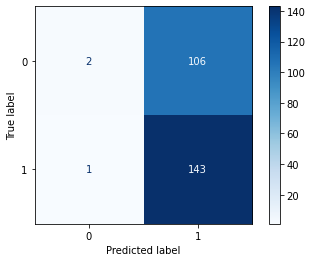

In [28]:
# Logistic Regression
lg_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', LogisticRegression(random_state=24))])

lg_clf.fit(X_train, y_train)

lg_result = evaluate_classification(lg_clf, X_train, y_train, X_test, y_test)
lg_result

### KNN

Train
-*-*-*-*-*-*-*-*
Accuracy: 0.8854 

Test
-*-*-*-*-*-*-*-*
Accuracy: 0.7421
              precision    recall  f1-score   support

           0       0.77      0.56      0.65       108
           1       0.73      0.88      0.79       144

    accuracy                           0.74       252
   macro avg       0.75      0.72      0.72       252
weighted avg       0.75      0.74      0.73       252



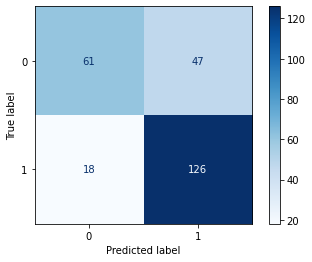

In [29]:
knn_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', KNeighborsClassifier())])

knn_clf.fit(X_train, y_train)

knn_result = evaluate_classification(knn_clf, X_train, y_train, X_test, y_test)
knn_result

### Random Forest

Train
-*-*-*-*-*-*-*-*
Accuracy: 1.0000 

Test
-*-*-*-*-*-*-*-*
Accuracy: 0.7024
              precision    recall  f1-score   support

           0       0.62      0.79      0.69       108
           1       0.80      0.64      0.71       144

    accuracy                           0.70       252
   macro avg       0.71      0.71      0.70       252
weighted avg       0.72      0.70      0.70       252



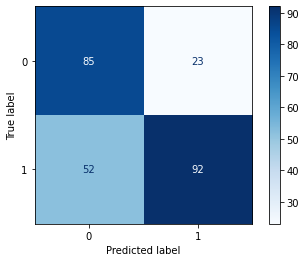

In [30]:
rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(criterion='entropy', random_state=24))])

rf_clf.fit(X_train, y_train)

rf_result = evaluate_classification(rf_clf, X_train, y_train, X_test, y_test)
rf_result

### XGBoost

Train
-*-*-*-*-*-*-*-*
Accuracy: 0.7621 

Test
-*-*-*-*-*-*-*-*
Accuracy: 0.5714
              precision    recall  f1-score   support

           0       0.50      0.09      0.16       108
           1       0.58      0.93      0.71       144

    accuracy                           0.57       252
   macro avg       0.54      0.51      0.43       252
weighted avg       0.54      0.57      0.47       252



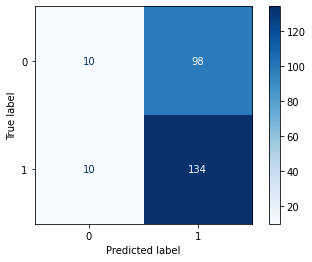

In [31]:
xgb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', XGBClassifier(random_state=24))])

xgb_clf.fit(X_train, y_train)

xgb_result = evaluate_classification(xgb_clf, X_train, y_train, X_test, y_test)
xgb_result

### AdaBoost

Train
-*-*-*-*-*-*-*-*
Accuracy: 1.0000 

Test
-*-*-*-*-*-*-*-*
Accuracy: 0.6587
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       108
           1       0.78      0.58      0.66       144
           2       0.00      0.00      0.00         0

    accuracy                           0.66       252
   macro avg       0.46      0.45      0.45       252
weighted avg       0.71      0.66      0.67       252



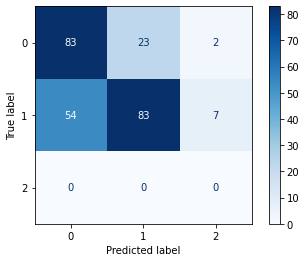

In [32]:
ada_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', AdaBoostClassifier(DecisionTreeClassifier(criterion='entropy', random_state=24)))])

ada_clf.fit(X_train, y_train)

ada_result = evaluate_classification(ada_clf, X_train, y_train, X_test, y_test)
ada_result

### Gradient Boosting

Train
-*-*-*-*-*-*-*-*
Accuracy: 0.7917 

Test
-*-*-*-*-*-*-*-*
Accuracy: 0.5635
              precision    recall  f1-score   support

           0       0.50      0.32      0.39       108
           1       0.60      0.74      0.66       144
           2       0.00      0.00      0.00         0

    accuracy                           0.56       252
   macro avg       0.37      0.36      0.35       252
weighted avg       0.56      0.56      0.55       252



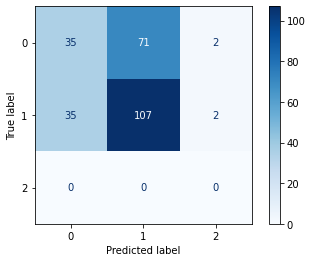

In [33]:
gb_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=24))])

gb_clf.fit(X_train, y_train)

gb_result = evaluate_classification(gb_clf, X_train, y_train, X_test, y_test)
gb_result

### Bagging

Train
-*-*-*-*-*-*-*-*
Accuracy: 0.9838 

Test
-*-*-*-*-*-*-*-*
Accuracy: 0.7103
              precision    recall  f1-score   support

           0       0.70      0.60      0.65       108
           1       0.73      0.79      0.76       144
           2       0.00      0.00      0.00         0

    accuracy                           0.71       252
   macro avg       0.48      0.46      0.47       252
weighted avg       0.71      0.71      0.71       252



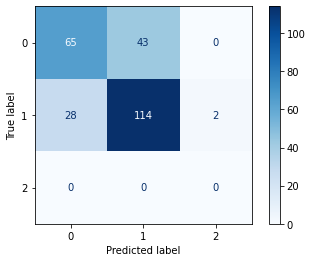

In [34]:
bag_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=24)))])

bag_clf.fit(X_train, y_train)

bag_result = evaluate_classification(bag_clf, X_train, y_train, X_test, y_test)
bag_result